## Brest cancer classifier

In [3]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import mixed_precision

from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model


import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2025-05-05 06:40:13.832038: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 06:40:13.840428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746420013.849622  227622 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746420013.852548  227622 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746420013.860192  227622 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### End-to-End CNN Strategy (1st)

#### Overview
Utilize a Convolutional Neural Network (CNN) to directly learn features from 50×50 histology image patches and classify them as benign (Class 0) or malignant (Class 1).

#### Key Steps

1. **Model Architecture**
   - **Convolutional Layers:** Automatically extract local features such as edges and textures.
   - **Pooling Layers:** Reduce spatial dimensions, making the model more robust to small translations.
   - **Fully Connected Layers:** Integrate the learned features to map them to a binary classification output.

2. **Data Augmentation**
   - **Techniques:** Apply rotations, flips, zooming, and shifts.
   - **Purpose:** Increase the effective size and variability of the dataset to reduce overfitting and improve generalization.

3. **Training with Labeled Data**
   - **Supervised Learning:** Use the provided labels with a loss function (e.g., cross-entropy) to train the network.
   - **Backpropagation:** Adjust the network weights iteratively to minimize classification errors.

4. **Optimization Techniques**
   - **Early Stopping:** Monitor validation performance to avoid overfitting.
   - **Learning Rate Scheduling:** Adapt the learning rate during training to ensure stable convergence.
   - **Dropout:** Randomly deactivate neurons during training to force the network to learn robust features.

5. **Evaluation Metrics**
   - **Metrics:** Assess performance using accuracy, precision, recall, and F1-score.
   - **Clinical Relevance:** Emphasize metrics that capture the balance between false positives and false negatives.

In [37]:
pwd


'/home/ali/Desktop/Uni/Master/M1/S2/APDN/Projet_lampert/Breast_Cancer'

In [38]:
ls ../


Breast_Cancer/  Data/


In [4]:
# -------------------------------
# Step 1: Build DataFrame from Directory Structure
# -------------------------------
data_dir = '../Data/'

filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith('.png'):  # now only PNG files
            file_path = os.path.join(root, file)
            label = os.path.basename(os.path.dirname(file_path))
            filepaths.append(file_path)
            labels.append(label)

# Create DataFrame
df = pd.DataFrame({
    'filename': filepaths,
    'class': labels
})

print(f"dataset shape : {df.shape}")


dataset shape : (277524, 2)


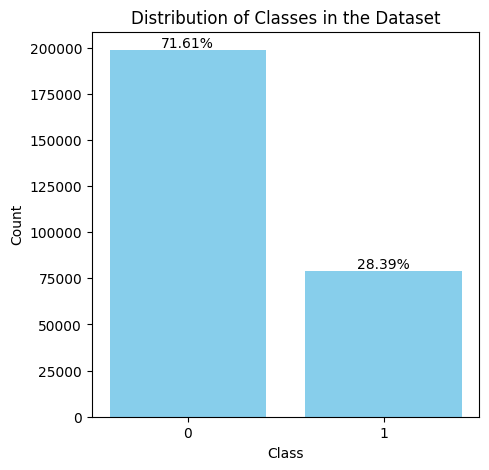

In [5]:
class_counts = df['class'].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100

plt.figure(figsize=(5, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Dataset')

# show percentages
for bar, percentage in zip(bars, class_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{percentage:.2f}%', 
             ha='center', va='bottom')

plt.show()

Imblananced data :
- So we will use Class weights, this helps the model learn to pay more attention to the underrepresented class. (used in this version)
- Can also use over/under sampling. (should compare the two approaches later)

In [6]:
# Define constants
TARGET_SIZE = (50, 50)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
# Split DataFrame into training and validation sets (80/20 split)
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42) # stratisfy also helps with the imblanced data

# Create a mapping from class names to integer labels
classes = sorted(df['class'].unique())
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
num_classes = len(classes)

# Map class labels to integer indices
train_df['label'] = train_df['class'].map(class_to_index)
valid_df['label'] = valid_df['class'].map(class_to_index)

# Compute class weights for handling imbalance
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight = {i: weight for i, weight in enumerate(class_weights_array)}

# -------------------------------
# Step 2: Setup tf.data Pipeline with Mixed Precision and Augmentation
# -------------------------------
# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

def preprocess_image(filename, label, training=False):
    # Read and decode the image using decode_png
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    # Resize and rescale
    image = tf.image.resize(image, TARGET_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Instantiate augmentation layers outside the function
rotation_layer = tf.keras.layers.RandomRotation(factor=0.1)

# carefully apllied to not alter the important pixels (features) from the images.
def augment_image(image, label):
    # Apply random flips (no risks here)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = rotation_layer(tf.expand_dims(image, 0))[0]
    
    # brightness, contrast, saturation, and hue (low settings)
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.90, upper=1.00)
    image = tf.image.random_saturation(image, lower=0.90, upper=1.00)
    image = tf.image.random_hue(image, max_delta=0.03)
    
    # Add minimal Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=image.dtype)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
    # a bit gamma
    gamma = tf.cast(tf.random.uniform([], 0.8, 1.2), image.dtype)
    image = tf.image.adjust_gamma(image, gamma=gamma)
    
    return image, label

# Create a Dataset from the training DataFrame
train_ds = tf.data.Dataset.from_tensor_slices((train_df['filename'].values, train_df['label'].values))
train_ds = train_ds.map(lambda f, l: preprocess_image(f, l, training=True), num_parallel_calls=AUTOTUNE) # process the images

## uncomment this to include the augmented data
# train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE) # augment the images
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create a Dataset from the validation DataFrame
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['filename'].values, valid_df['label'].values))
valid_ds = valid_ds.map(lambda f, l: preprocess_image(f, l, training=False), num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)



# One-hot encode the labels within the dataset
def one_hot(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

train_ds = train_ds.map(one_hot, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(one_hot, num_parallel_calls=AUTOTUNE)


I0000 00:00:1746420021.336888  227622 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 132 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1746420021.346035  227622 cuda_executor.cc:479] failed to allocate 132.25MiB (138674176 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1746420021.346085  227622 cuda_executor.cc:479] failed to allocate 119.02MiB (124806912 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1746420021.346121  227622 cuda_executor.cc:479] failed to allocate 107.12MiB (112326400 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1746420021.346157  227622 cuda_executor.cc:479] failed to allocate 96.41MiB (101093888 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1746420021.346192  22

Before we start setting up the model, let's see the state of data we will be using.

In [44]:

# -------------------------------
# Step 3: Define the CNN Model (Unchanged for now)
# -------------------------------

input = Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

filters = [32, 64, 128]

x = input
for f in filters :
    x = Conv2D(f, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0,15)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0,15)(x)
x = Dense(32, activation='relu')(x)

output = Dense(num_classes, activation='softmax', dtype='float32')(x)
model = Model(inputs = input, outputs = output, name = "CNN1")


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "CNN1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,922 (1.40 MB)

 Trainable params: 365,922 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# -------------------------------
# Step 4: Train the Model with Class Weights
# -------------------------------
epochs = 10
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    class_weight=class_weight  # applying class weights for imbalanced data
)

Epoch 1/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7691 - loss: 0.4891 - val_accuracy: 0.7705 - val_loss: 0.4976
Epoch 2/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8234 - loss: 0.4053 - val_accuracy: 0.8331 - val_loss: 0.3817
Epoch 3/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8329 - loss: 0.3825 - val_accuracy: 0.8437 - val_loss: 0.3581
Epoch 4/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8394 - loss: 0.3708 - val_accuracy: 0.8380 - val_loss: 0.3608
Epoch 5/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8422 - loss: 0.3647 - val_accuracy: 0.8608 - val_loss: 0.3246
Epoch 6/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8464 - loss: 0.3625 - val_accuracy: 0.8355 - val_loss: 0.3738
Epoch 7/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8480 - loss: 0.3550 - val_accuracy: 0.8541 - val_loss: 0.3380
Epoch 8/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8480 - loss: 0.3547

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step


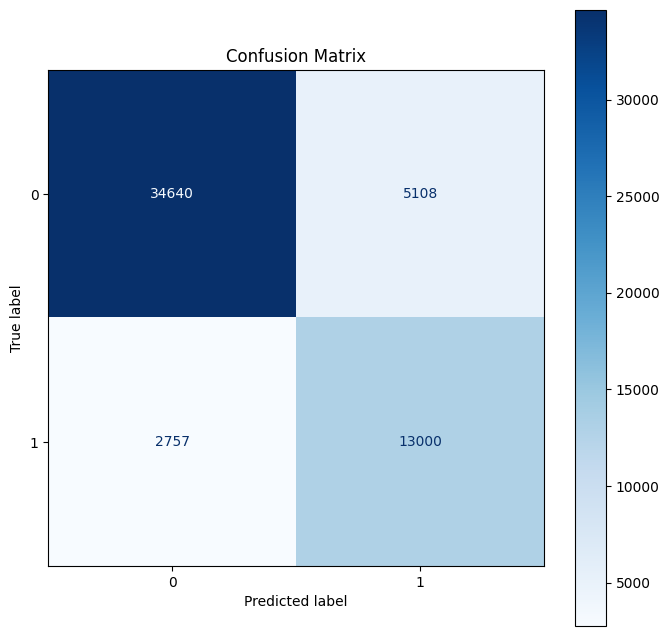

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predict on the entire validation set
y_pred_probs = model.predict(valid_ds)  
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Extract true labels from the dataset
#    Assuming valid_ds yields (image_batch, one_hot_label_batch)
y_true = np.concatenate([
    np.argmax(label_batch.numpy(), axis=1)
    for _, label_batch in valid_ds
], axis=0)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4a. Plot with sklearn’s built-in function
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.show()


In [8]:
classes

['0', '1']

In [ ]:
probs_val = model.predict(valid_ds)              # shape (N_val, 2)
p_mal_val = probs_val[:, 1]                   # take malignant‐class score


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step


In [60]:
labels_ds = valid_ds.map(lambda img, lbl: lbl)

In [61]:
valid_labels = np.concatenate([batch.numpy() for batch in labels_ds], axis=0)


2025-05-05 03:42:51.826252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [67]:
valid_label = np.argmax(valid_labels, axis=1).astype(int)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(valid_label, p_mal_val, pos_label=1)
specificity =  fpr   # true negative rate

In [222]:
target_spec = 0.30
# find the lowest threshold that yields that specificity
idx = np.where(specificity >= target_spec)[0]
if len(idx)>0:
    chosen_thresh = thresh[idx[-1]]   # largest threshold still ≥ 95% spec
else:
    chosen_thresh = 0.5               # fall back to default

print(f"Chosen malignant cutoff: {chosen_thresh:.2f}, "
      f"Specificity: {specificity[idx[-1]]:.3f}, "
      f"Sensitivity: {tpr[idx[-1]]:.3f}")

Chosen malignant cutoff: 0.03, Specificity: 0.300, Sensitivity: 0.992


In [223]:
def predict_with_thresh(X, model, thresh):
    probs = model.predict(X)[:,1]      # p(malignant)
    # 1 = malignant, 0 = benign
    return (probs > thresh).astype(int)

y_pred_val = predict_with_thresh(valid_ds, model, chosen_thresh)

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step


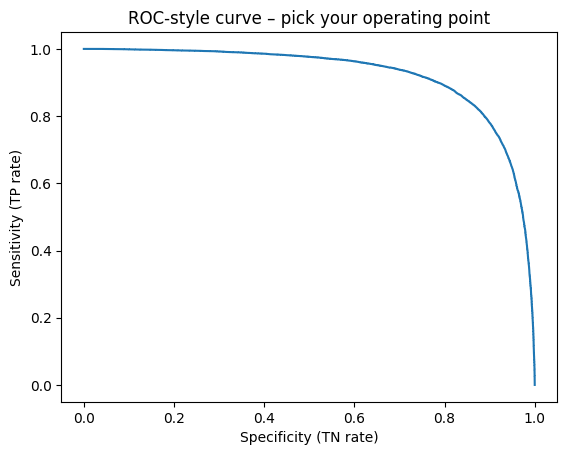

In [201]:
plt.plot(1-fpr, tpr)
plt.xlabel("Specificity (TN rate)")
plt.ylabel("Sensitivity (TP rate)")
plt.title("ROC‐style curve – pick your operating point")
plt.show()

In [224]:
probs_val = model.predict(valid_ds)[:,1]               # p(malignant)
y_pred_val = (probs_val > chosen_thresh).astype(int)  

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step


In [225]:
cm = confusion_matrix(valid_label, y_pred_val, labels=[0,1])

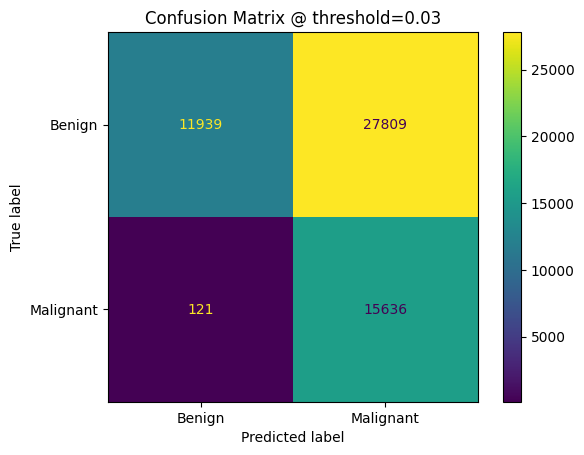

In [226]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benign','Malignant']
)
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.title(f'Confusion Matrix @ threshold={chosen_thresh:.2f}')
plt.show()